In [1]:
%matplotlib inline

import os
from pytorch_metric_learning import losses, miners, samplers, trainers, testers, distances
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap.umap_ as umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import pandas as pd
from tqdm import tqdm_notebook
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from random import randint
from os.path import expanduser

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)

INFO:root:VERSION 0.9.98


# Veri setini hazirlama

In [2]:
df_shopee = pd.read_csv('/home/twoaday/research/data-sets/shopee/shopee-product-matching/train.csv')
df_shopee.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [3]:
stanford_file_list = []
for parent_path, _, filenames in tqdm_notebook(os.walk(
    '/home/twoaday/research/data-sets/stanford/Stanford_Online_Products')):
    for f in filenames:
        if '.JPG' in f or '.jpg' in f:
            stanford_file_list.append(os.path.join(parent_path, f))
stanford_file_list[0]

df_stanford = []
for f in tqdm_notebook(stanford_file_list):
    label = f.split('/')[-1].split('_')[0]
    df_stanford.append({'label':f'st_{label}', 'image_path': f})
df = pd.DataFrame(df_stanford)
df.sample()

<ipython-input-3-79e9743707e3>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for parent_path, _, filenames in tqdm_notebook(os.walk(


0it [00:00, ?it/s]

<ipython-input-3-79e9743707e3>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm_notebook(stanford_file_list):


  0%|          | 0/120053 [00:00<?, ?it/s]

,label,image_path
73066,st_391218411487,/home/twoaday/research/data-sets/stanford/Stan...


In [4]:
df.label = pd.Categorical(df.label)
df['label'] = df.label.cat.codes

In [5]:
df.head()

,label,image_path
0,14798,/home/twoaday/research/data-sets/stanford/Stan...
1,2424,/home/twoaday/research/data-sets/stanford/Stan...
2,9306,/home/twoaday/research/data-sets/stanford/Stan...
3,6298,/home/twoaday/research/data-sets/stanford/Stan...
4,7444,/home/twoaday/research/data-sets/stanford/Stan...


# Modeller

In [6]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]
        self._softmax = nn.Softmax(dim=1)
    def forward(self, x):
        out = self.net(x) 
        return self._softmax(out)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.wide_resnet101_2(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))
embedding_size = 256
# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, embedding_size]).to(device))

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.0001, weight_decay=0.0001)



# Augmentation & Transformation

In [8]:
# Set the image transforms
train_transform = transforms.Compose([transforms.Resize((64, 64)),
                                    # transforms.RandomRotation(degrees=(0, 180)),
                                    transforms.RandomHorizontalFlip(0.5),
                                    # transforms.RandomVerticalFlip(0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize((64, 64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

## Veriyi train ve validation olarak ikiye ayiriyoruz

In [9]:
pids = df.label.unique()

val_set = np.random.choice(pids, 2000)
df_test = df.loc[df.label.isin(val_set)]
df_train = df.loc[~df.label.isin(val_set)]

logging.info(f'Train size: {len(df_train)} Validation size: {len(df_test)}')

INFO:root:Train size: 109820 Validation size: 10233


# Veriyi modele beslemek icin data seti olusturuyoruz

In [10]:
class ProductImageDataSet(torch.utils.data.Dataset):
    def __init__(self, data_set, train, transform):
        self.data = data_set.image_path.values
        self.targets = data_set.label.values
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):            
        if isinstance(index, slice):
            img, target = self.data[index.start], self.targets[index.start]
            img = Image.open(img).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            return img.unsqueeze(0).to(device)
        else:
            img, target = self.data[index], self.targets[index]
            img = Image.open(img).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            return img, target

In [11]:
train_dataset = ProductImageDataSet(df_train, True, train_transform)
val_dataset = ProductImageDataSet(df_test,  False, val_transform)

## Hyperparameters

In [12]:
# Set the loss function
loss = losses.CircleLoss(m=0.4)

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(train_dataset.targets, 
                                    m=2, 
                                    length_before_new_iter=len(train_dataset))

# Set other training parameters
batch_size = 32
num_epochs = 20

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

## Gorsellestirme ve loglama

In [13]:
model_name = f'wide_resnet101_2_circle_softmax_{batch_size}_{embedding_size}'
HOME = expanduser("~")
DL_MODELS_PATH = HOME + f'/trained_models/matching/images/{model_name}'

record_keeper, _, _ = logging_presets.get_record_keeper("/tmp/",
                f"/home/twoaday/tensorboard_logs/project_kusanagi/images/{model_name}")
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = DL_MODELS_PATH

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
    label_set = np.unique(labels)
    num_classes = len(label_set)
    fig = plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)   
    plt.show()

# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                            visualizer = umap.UMAP(), 
                                            visualizer_hook = visualizer_hook,
                                            dataloader_num_workers = 8,
                                            accuracy_calculator=AccuracyCalculator(k="max_bin_count"))

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_folder, 
                                            test_interval = 1,
                                            patience = 1)

# Training

In [14]:
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 16,
                                end_of_iteration_hook = hooks.end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_hook)

INFO:PML:Initializing dataloader
/home/twoaday/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
  0%|          | 0/2588 [00:00<?, ?it/s]/home/twoaday/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:11

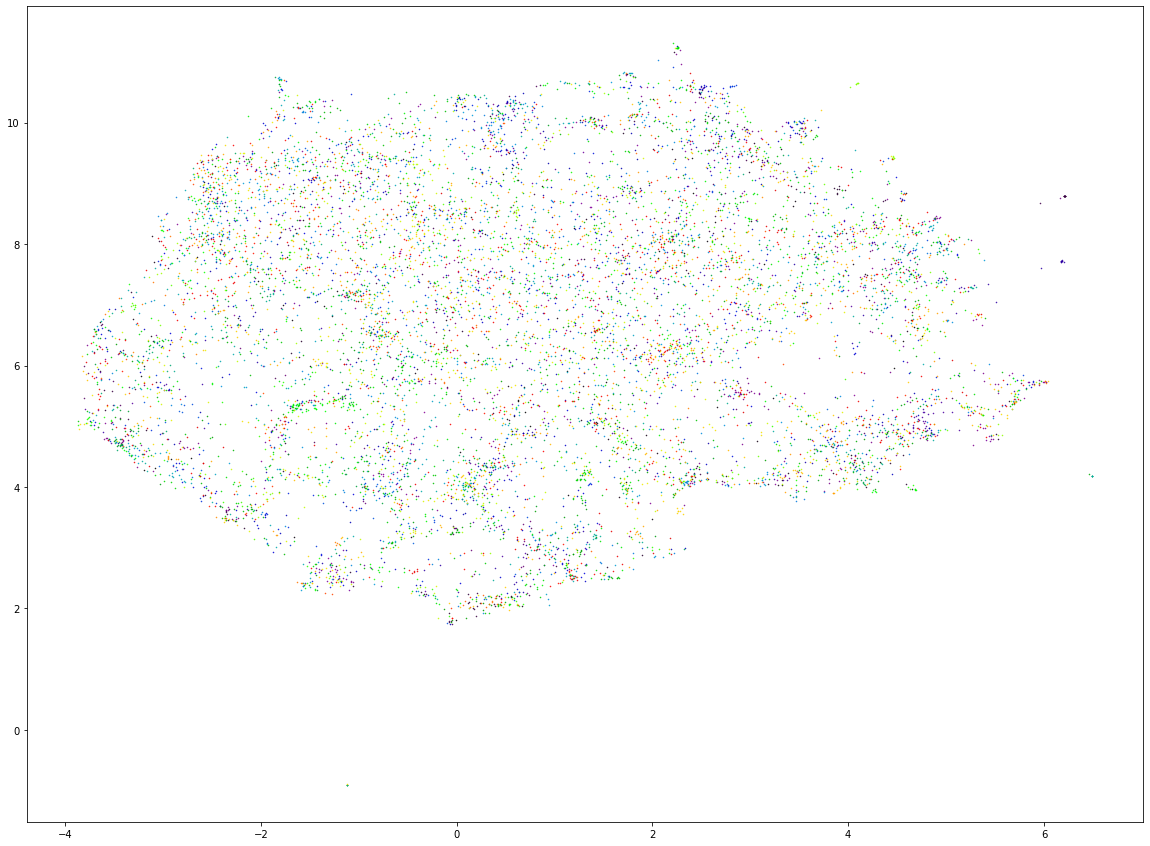

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=12
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=1927
INFO:PML:embedding dimensionality is 256
INFO:PML:New best accuracy! 0.15333804104513246
INFO:PML:TRAINING EPOCH 2
  0%|          | 0/2588 [00:00<?, ?it/s]/home/twoaday/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total_loss=20.05111: 100%|██████████| 2588/2588 [08:42<00:00,  4.96it/s]
INFO:PML:Evaluating epoch 2
INFO:PML:Getting embeddings for the val split
100%|██████████| 329/329 [00:

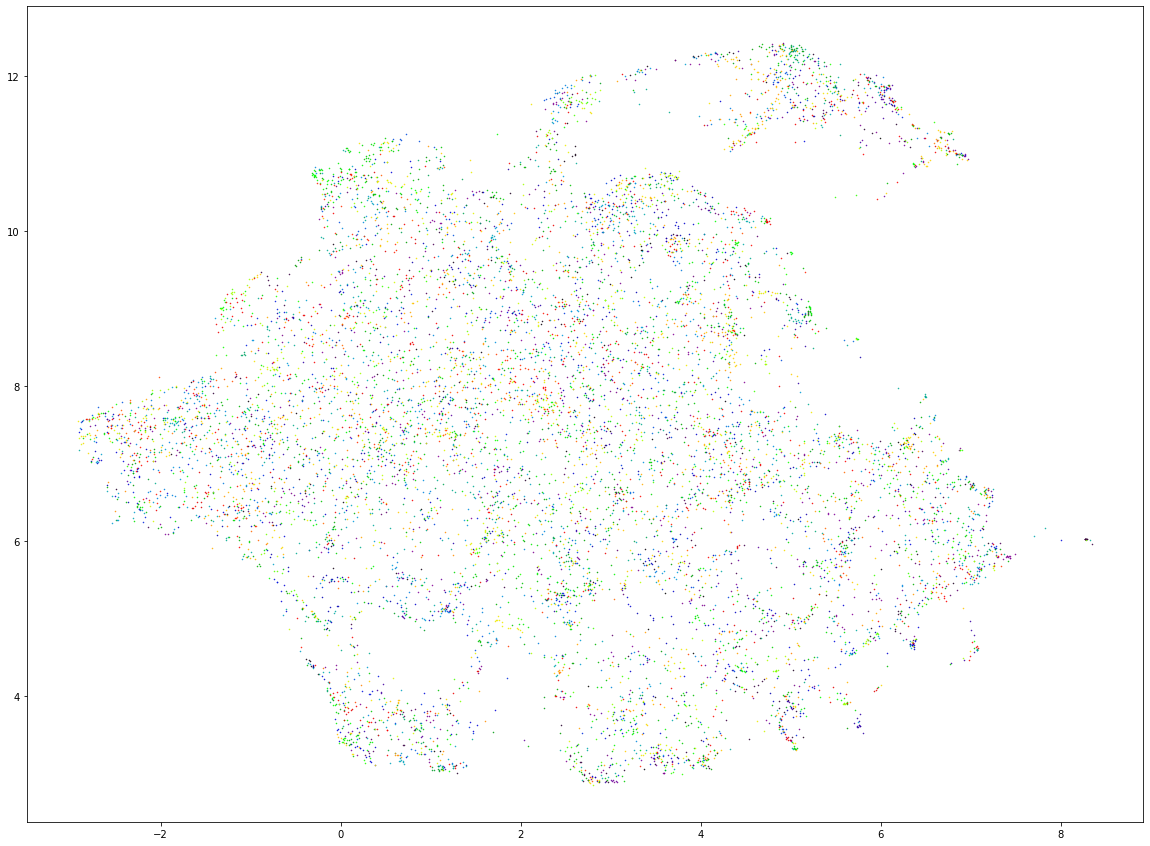

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=12
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=1927
INFO:PML:embedding dimensionality is 256
INFO:PML:New best accuracy! 0.20615497326233442
INFO:PML:TRAINING EPOCH 3
  0%|          | 0/2588 [00:00<?, ?it/s]/home/twoaday/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total_loss=20.34027: 100%|██████████| 2588/2588 [08:43<00:00,  4.94it/s]
INFO:PML:Evaluating epoch 3
INFO:PML:Getting embeddings for the val split
100%|██████████| 329/329 [00:

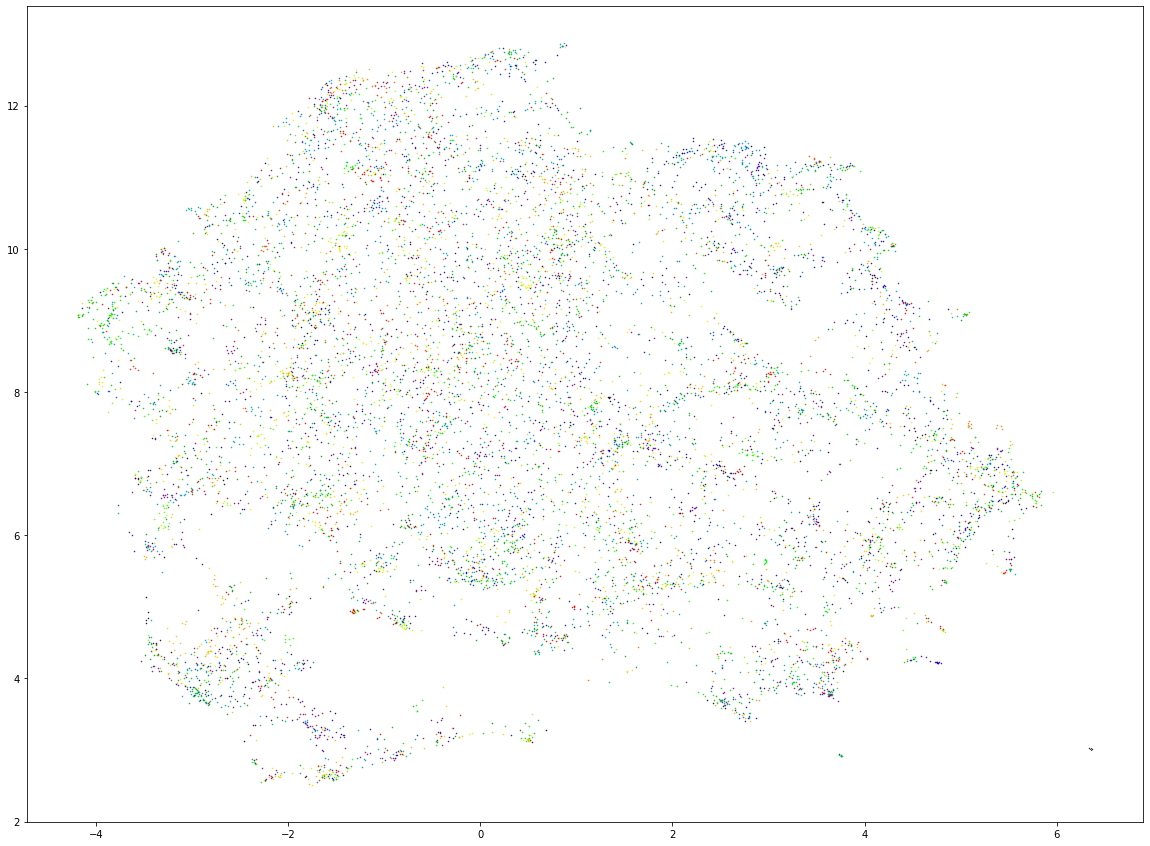

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=12
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=1927
INFO:PML:embedding dimensionality is 256
INFO:PML:New best accuracy! 0.24355258441146996
INFO:PML:TRAINING EPOCH 4
  0%|          | 0/2588 [00:00<?, ?it/s]/home/twoaday/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total_loss=20.44556: 100%|██████████| 2588/2588 [08:54<00:00,  4.84it/s]
INFO:PML:Evaluating epoch 4
INFO:PML:Getting embeddings for the val split
100%|██████████| 329/329 [00:

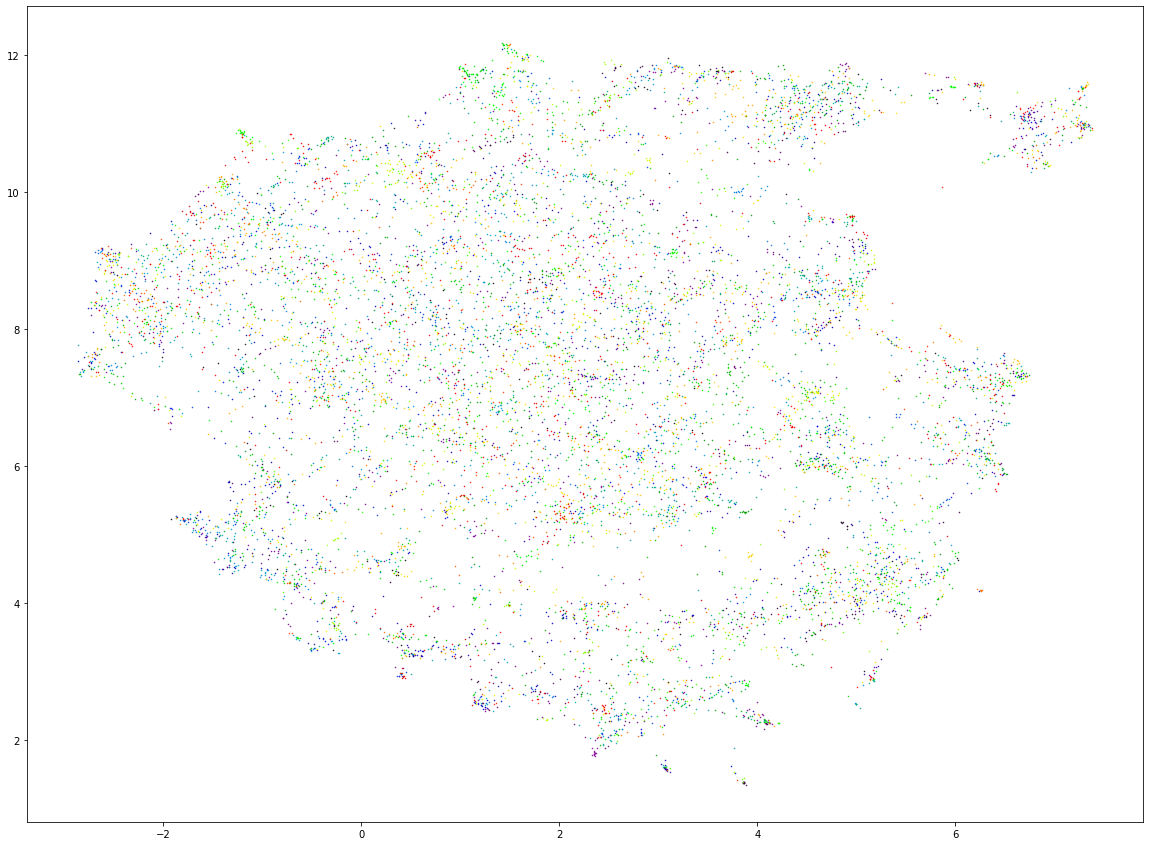

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=12
INFO:PML:embedding dimensionality is 256
INFO:PML:running k-means clustering with k=1927
INFO:PML:embedding dimensionality is 256
INFO:PML:New best accuracy! 0.25838463682764173
INFO:PML:TRAINING EPOCH 5
  0%|          | 0/2588 [00:00<?, ?it/s]/home/twoaday/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total_loss=20.63418:  60%|██████    | 1554/2588 [05:14<03:29,  4.95it/s]


KeyboardInterrupt: 

In [15]:
trainer.train(num_epochs=num_epochs)

# Resimleri bastirmak icin

In [15]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Egittigimiz modeli yukluyoruz

In [16]:
class CombinedVectorizer(nn.Module):
    def __init__(self, trunk_model, embedder):
        super(CombinedVectorizer, self).__init__()
        self._trunk = trunk_model
        self._embedder = embedder

    def forward(self, title):
        x = self._trunk(title)
        return self._embedder(x)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.wide_resnet101_2(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
embedding_size = 256

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = MLP([trunk_output_size, embedding_size]).to(device)
trunk_path = f'/home/twoaday/trained_models/matching/images/{model_name}/trunk_11.pth'
embedder_path = f'/home/twoaday/trained_models/matching/images/{model_name}/embedder_11.pth'
trunk.load_state_dict(torch.load(trunk_path, map_location=device))
embedder.load_state_dict(torch.load(embedder_path, map_location=device))

model = CombinedVectorizer(trunk, embedder).to(device)
model.eval()

CombinedVectorizer(
  (_trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

# Resim arama

In [18]:
transform = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize(mean=mean, std=std)])
labels_to_indices = c_f.get_labels_to_indices(val_dataset.targets)

In [19]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
# model.cuda()
inference_model = InferenceModel(model, match_finder=match_finder)
inference_model.train_indexer(val_dataset, embedding_size)

query image


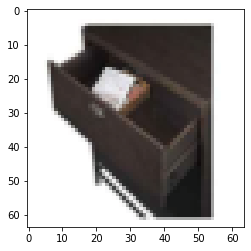

nearest images


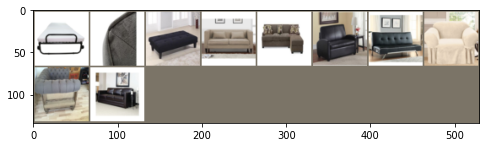

In [20]:
index_no = randint(0, len(val_dataset))
img = val_dataset[index_no][0].unsqueeze(0)
print("query image")
imshow(torchvision.utils.make_grid(img))
indices, distances = inference_model.get_nearest_neighbors(img.to(device), k=10)
nearest_imgs = [val_dataset[i][0] for i in indices[0]]
print("nearest images")
imshow(torchvision.utils.make_grid(nearest_imgs))